In [1]:
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', None)
#import os
#import re
import matplotlib.pyplot as plt
#import pickle
from IPython.display import display, Markdown
import seaborn as sns
from math import floor
import ast
import json
import re
import numpy as np

from dbmsbenchmarker import parameter, inspector

#import dbmsbenchmarker
#import bexhoma
from bexhoma import evaluators

%matplotlib inline

In [2]:
path = r"C:\data\benchmarks"
#path = r"/home/perdelt/benchmarks"

In [3]:
def get_workload(code):
    with open(path+"/"+code+"/queries.config",'r') as inp:
        workload_properties = ast.literal_eval(inp.read())
        return workload_properties

def map_index_to_queryname(numQuery):
    global query_properties
    if numQuery[1:] in query_properties and 'config' in query_properties[numQuery[1:]] and 'title' in query_properties[numQuery[1:]]['config']:
        return query_properties[numQuery[1:]]['config']['title']
    else:
        return numQuery

def get_df_benchmarking(evaluate):
    global query_properties
    #evaluate = inspector.inspector(path)
    #evaluate.load_experiment(code=code, silent=True)
    query_properties = evaluate.get_experiment_query_properties()
    num_of_queries = 0
    df = evaluate.get_aggregated_query_statistics(type='latency', name='execution', query_aggregate='Mean')
    if not df is None:
        df = df.sort_index().T.round(2)
        df.index = df.index.map(map_index_to_queryname)
        #print(df)
        num_of_queries = len(df.index)
    #print("\n### Power@Size ((3600*SF)/(geo times))")
    df = evaluate.get_aggregated_experiment_statistics(type='timer', name='execution', query_aggregate='Median', total_aggregate='Geo')
    df = (df/1000.0).sort_index().astype('float')
    df['Power@Size [~Q/h]'] = float(parameter.defaultParameters['SF'])*3600./df
    #df.columns = ['Power@Size [~Q/h]']
    df_power = df.copy()
    #print(df.round(2))
    #print(parameter.defaultParameters['SF'])
    #print("\n### Geometric Mean of Medians of Timer Run [s]")
    df = evaluate.get_aggregated_experiment_statistics(type='timer', name='run', query_aggregate='Median', total_aggregate='Geo')
    df = (df/1000.0).sort_index()
    df.columns = ['Geo Times [s]']
    df_geo_mean_runtime = df.copy()
    #print(df.round(2))
    df = pd.concat([df_power, df_geo_mean_runtime], axis=1)
    #df_time = df.copy()
    df_merged_time = pd.DataFrame()
    for connection_nr, connection in evaluate.benchmarks.dbms.items():
        df_time = pd.DataFrame()
        c = connection.connectiondata
        connection_name = c['name']
        orig_name = c['orig_name']
        eva = evaluate.get_experiment_connection_properties(c['name'])
        df_time.index = [connection_name]
        #df_time['SF'] = int(SF)
        #print(c)
        #print(connection.name)
        #print(connection.connection)
        df_time['orig_name'] = orig_name
        df_time['connection_name'] = connection_name
        df_time['SF'] = float(c['parameter']['connection_parameter']['loading_parameters']['SF'])
        df_time['pods'] = int(c['parameter']['connection_parameter']['loading_parameters']['PODS_PARALLEL'])
        #df_time['threads'] = int(c['parameter']['connection_parameter']['loading_parameters']['MYSQL_LOADING_THREADS'])
        df_time['num_experiment'] = int(c['parameter']['numExperiment'])
        df_time['num_client'] = int(c['parameter']['client'])
        df_time['benchmark_start'] = eva['times']['total'][c['name']]['time_start']
        df_time['benchmark_end'] = eva['times']['total'][c['name']]['time_end']
        df_merged_time = pd.concat([df_merged_time, df_time])
    df_time = df_merged_time.sort_index()
    # aggregate per parallel pods per dbms - not valid for model=container?
    #benchmark_start = df_time.groupby(['orig_name', 'SF', 'num_experiment', 'num_client']).min('benchmark_start')
    #benchmark_end = df_time.groupby(['orig_name', 'SF', 'num_experiment', 'num_client']).max('benchmark_end')
    benchmark_start = df_time.groupby(['connection_name', 'SF', 'num_experiment', 'num_client']).min('benchmark_start')
    benchmark_end = df_time.groupby(['connection_name', 'SF', 'num_experiment', 'num_client']).max('benchmark_end')
    df_benchmark = pd.DataFrame(benchmark_end['benchmark_end'] - benchmark_start['benchmark_start'])
    df_benchmark.columns = ['time [s]']
    #benchmark_count = df_time.groupby(['orig_name', 'SF', 'num_experiment', 'num_client']).count()
    benchmark_count = df_time.groupby(['connection_name', 'SF', 'num_experiment', 'num_client']).count()
    df_benchmark['count'] = benchmark_count['benchmark_end']
    df_benchmark['SF2'] = df_benchmark.index.map(lambda x: x[1])
    df_benchmark['Throughput@Size'] = (num_of_queries*3600.*df_benchmark['count']/df_benchmark['time [s]']*df_benchmark['SF2']).round(2)
    #df_benchmark['Throughput@Size [~GB/h]'] = (22*3600.*df_benchmark['count']/df_benchmark['time [s]']*df_benchmark['SF']).round(2)
    index_names = list(df_benchmark.index.names)
    #print(index_names)
    index_names[0] = "DBMS"
    df_benchmark.rename_axis(index_names, inplace=True)
    df_benchmark = df_benchmark.reset_index(level=['SF', 'num_experiment', 'num_client'])
    #print(df_benchmark)
    #return df_benchmark
    #df.index = df.index.map(lambda x: str(x)[:-2])
    #print(evaluate.e.benchmarker.code, df.index.duplicated())
    df = pd.concat([df, df_benchmark], axis=1)
    df.drop('SF2', axis=1, inplace=True)
    df.rename(columns={'num_experiment': 'experiment_run'}, inplace=True)
    df.rename(columns={'num_client': 'client'}, inplace=True)
    #df = df.sort_values('orig_name')
    df['Power@Size [~Q/h]'] = df['SF']*3600./df['total_timer_execution']
    return df

def get_performance_single(evaluation):
    df = get_df_benchmarking(evaluation)
    #print(df)
    df = df.sort_values(['experiment_run', 'client'])
    return df

def get_performance(evaluation):
    df = get_df_benchmarking(evaluation)
    df = df.sort_values(['experiment_run', 'client'])
    result = df.groupby('client').agg({
        'Throughput@Size': 'sum',
        #'num_errors': 'sum',
        #'Latency Distribution.Average Latency (microseconds)': 'mean'
    }).reset_index()
    return result

def get_performance_all(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = inspector.inspector(path)
        evaluation.load_experiment(code=code, silent=True)
        #evaluation = evaluators.base(code=code, path=path)
        workload = get_workload(code)
        df = get_performance(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance

def get_performance_all_single(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = inspector.inspector(path)
        evaluation.load_experiment(code=code, silent=True)
        #evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_performance_single(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance

def get_loading_time_max(evaluation):
    with open(path+"/"+evaluation.code+"/connections.config",'r') as inf:
        connections = ast.literal_eval(inf.read())
        pretty_connections = json.dumps(connections, indent=2)
        #print(pretty_connections)
        connections_sorted = sorted(connections, key=lambda c: c['name'])
        result = dict()
        for c in connections_sorted:
            result[c['name']] = {
                'time_load': c['timeLoad'],
                'time_ingest': c['timeIngesting'],
                'time_check': c['timeIndex'],
                #'terminals': c['parameter']['connection_parameter']['loading_parameters']['BENCHBASE_TERMINALS'],
                #'target': c['parameter']['connection_parameter']['loading_parameters']['BENCHBASE_TARGET'],
                'pods': c['parameter']['parallelism'],
                'tenant': c['parameter']['TENANT'] if 'TENANT' in c['parameter'] else '',
                'client': c['parameter']['client'],
                'datadisk': c['hostsystem']['datadisk'],
            }
            #result[c['parameter']['connection_parameter']['loading_parameters']['BENCHBASE_TERMINALS']] = c['timeIngesting']
        df = pd.DataFrame(result).T
        return df#df['time_load'].max()

def get_loading_time_max_all(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_loading_time_max(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance

def show_summary_monitoring_table(evaluate, component):
    df_monitoring = list()
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_util_s', component=component)
    df = df.max().sort_index() - df.min().sort_index() # compute difference of counter
    #df = df.T.max().sort_index() - df.T.min().sort_index() # compute difference of counter
    df_cleaned = pd.DataFrame(df)
    df_cleaned.columns = ["CPU [CPUs]"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_util', component=component)
    df = df.max().sort_index()
    df_cleaned = pd.DataFrame(df)
    df_cleaned.columns = ["Max CPU"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_memory', component=component)/1024
    #df = evaluate.get_loading_metrics('total_cpu_memory')/1024
    df = df.max().sort_index()
    df_cleaned = pd.DataFrame(df).round(2)
    df_cleaned.columns = ["Max RAM [Gb]"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_memory_cached', component=component)/1024
    #df = evaluate.get_loading_metrics('total_cpu_memory_cached')/1024
    df = df.max().sort_index()
    df_cleaned = pd.DataFrame(df)
    df_cleaned.columns = ["Max RAM Cached [Gb]"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    return df_monitoring

def get_monitoring_stream_single(evaluation):
    df_monitoring = show_summary_monitoring_table(evaluation, "stream")
    if len(df_monitoring) > 0:
        #print("\n### Stream SUT")
        df = pd.concat(df_monitoring, axis=1).round(2)
        df = df.reindex(index=evaluators.natural_sort(df.index))
        # If your DataFrame is named df and the index is a string like 'PostgreSQL-1-1-1024-0-1'
        df = df.copy()  # avoid modifying original
        df['client'] = df.index.str.rsplit('-', n=1).str[-1]
        #print(df)
        return df

def get_monitoring_stream(evaluation):
    df_monitoring = show_summary_monitoring_table(evaluation, "stream")
    if len(df_monitoring) > 0:
        #print("\n### Stream SUT")
        df = pd.concat(df_monitoring, axis=1).round(2)
        df = df.reindex(index=evaluators.natural_sort(df.index))
        # If your DataFrame is named df and the index is a string like 'PostgreSQL-1-1-1024-0-1'
        df = df.copy()  # avoid modifying original
        df['client'] = df.index.str.rsplit('-', n=1).str[-1]
        #print(df)
        result = df.groupby('client').agg({
            'CPU [CPUs]': 'sum',
            'Max RAM [Gb]': 'sum',
            'Max RAM Cached [Gb]': 'sum',
            'Max CPU': 'sum',
        }).reset_index()
        return result

def get_monitoring_stream_all(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_monitoring_stream(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance


In [4]:
def sanitize_filename(title, max_length=100):
    # Replace non-alphanumeric characters with underscores
    safe = re.sub(r'[^a-zA-Z0-9-_]+', '_', title.strip())
    # Truncate to a safe length
    return safe[:max_length].rstrip('_')
    
def plot_bars(df, y, title, estimator):
    df_plot = df.copy()
    #df_plot = df_plot[df_plot['client']=='1']
    df_plot = df_plot.sort_values(['num_tenants','type'])
    # Hatch styles for each type
    hatch_map = {
        'container': '/',
        'database': '\\',
        'schema': 'x'
    }
    hue_order = ['container', 'database', 'schema']
    # Create the plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=df_plot,
        x='num_tenants',
        y=y,
        hue='type',
        estimator=estimator,
        palette='Set2',
        hue_order=hue_order
    )
    for bar in ax.patches:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # X: center of bar
                height,                             # Y: top of bar
                f'{height:.1f}',                    # Text (1 decimal place)
                ha='center', va='bottom', fontsize=8
            )
    # Get tick positions (i.e., the x-axis categories)
    xticks = ax.get_xticks()
    bar_width = ax.patches[0].get_width()
    # Create a mapping from (num_tenants, type) to hatch
    grouped = df_plot.groupby(['num_tenants', 'type']).agg({y: estimator}).reset_index()
    #print(grouped)
    grouped_dict = {(row['num_tenants'], row['type']): hatch_map[row['type']] for _, row in grouped.iterrows()}
    bars = sorted(ax.patches, key=lambda bar: bar.get_x() if bar.get_height() > 0 else 10000)
    for bar, (_, row) in zip(bars, grouped.iterrows()):
        bar.my_id = (row['num_tenants'], row['type'])  # or anything else like an index or uuid
        bar.set_hatch(hatch_map[row['type']]) #grouped_dict[(bar.my_id)])
        bar.set_edgecolor('black')
        bar.set_linewidth(1)
    handles, labels = ax.get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        hatch = hatch_map.get(label, '')
        handle.set_hatch(hatch)
    # Final touches
    plt.legend(title='Type')
    ax.legend(fontsize=18)
    #ax.legend(fontsize=18, loc='upper left', bbox_to_anchor=(1, 1))  # move outside
    plt.title(f"{title}", fontsize=24)
    #plt.title(f"{title} by Number of Tenants and Type", fontsize=24)
    plt.xlabel("Number of Tenants", fontsize=18)
    ax.tick_params(axis='both', labelsize=16)
    # Remove y-axis label
    ax.set_ylabel('')  # or ax.set(ylabel='')
    plt.tight_layout()
    filename = "tpch_" + sanitize_filename(title) + ".png"    
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()



# Container

In [5]:
codes = [
    # container
    '1750860691', #tenants=1
    '1750862759', #tenants=2
    '1750865137', #tenants=3
    '1750867875', #tenants=4
    '1750870795', #tenants=5
    '1750874081', #tenants 6
    '1750877615', #tenants=7
    '1750881535', #tenants=8
    '1750885773', #tenants=9
    '1750890605', #tenants=10
    
    # database
    '1750860068', #tenants=1
    '1750862031', #tenants=2
    '1750864344', #tenants=3
    '1750866970', #tenants=4
    '1750869887', #tenants=5
    '1750873072', #tenants=6
    '1750876552', #tenants=7
    '1750880303', #tenants=8
    '1750884409', #tenants=9
    '1750889051', #tenants=10
    
    #schema
    '1750859440', #tenants=1
    '1750861312', #tenants=2
    '1750863504', #tenants=3
    '1750866067', #tenants=4
    '1750868888', #tenants=5
    '1750871956', #tenants=6   
    '1750875370', #tenants=7
    '1750879076', #tenants=8
    '1750883132', #tenants=9
    '1750887555', #tenants=10
]

In [6]:
codes = ['1751049830', '1751042932', '1751036351', '1751030495', '1751024409', '1751018248']

codes

['1751049830',
 '1751042932',
 '1751036351',
 '1751030495',
 '1751024409',
 '1751018248']

In [7]:
df_performance = get_performance_all_single(codes)
df_performance

,total_timer_execution,Power@Size [~Q/h],Geo Times [s],SF,experiment_run,client,time [s],count,Throughput@Size,type,num_tenants
DBMS,,,,,,,,,,,
PostgreSQL-BHT-1-0-1-1,5.581958,6449.350079,5.581958,10.0,1,1,1931,1,410.15,container,2
PostgreSQL-BHT-1-1-1-1,5.725308,6287.871693,5.725308,10.0,1,1,1961,1,403.88,container,2
PostgreSQL-BHT-1-0-2-1,5.600174,6428.371549,5.600174,10.0,1,2,1928,1,410.79,container,2
PostgreSQL-BHT-1-1-2-1,5.662387,6357.742695,5.662387,10.0,1,2,1935,1,409.30,container,2
PostgreSQL-BHT-2-1-1,5.805220,6201.315561,5.805220,10.0,1,1,1980,1,400.00,database,2
PostgreSQL-BHT-2-1-2,5.859996,6143.349100,5.859996,10.0,1,1,1995,1,396.99,database,2
PostgreSQL-BHT-2-2-1,5.786509,6221.367407,5.786509,10.0,1,2,1967,1,402.64,database,2
PostgreSQL-BHT-2-2-2,5.816515,6189.273202,5.816515,10.0,1,2,1983,1,399.39,database,2
PostgreSQL-BHT-2-1-1,5.804136,6202.473081,5.804136,10.0,1,1,1999,1,396.20,schema,2


In [8]:
df_multi = df_performance.set_index(['num_tenants', 'type'])
df_multi

total_timer_execution  Power@Size [~Q/h]  \
num_tenants type                                                  
2           container               5.581958        6449.350079   
            container               5.725308        6287.871693   
            container               5.600174        6428.371549   
            container               5.662387        6357.742695   
            database                5.805220        6201.315561   
            database                5.859996        6143.349100   
            database                5.786509        6221.367407   
            database                5.816515        6189.273202   
            schema                  5.804136        6202.473081   
            schema                  5.799652        6207.269260   
            schema                  5.818923        6186.711568   
            schema                  5.805793        6200.703804   
1           container               5.578556        6453.282885   
            container               5.625816        6399.072262   
            database                5.782133        6226.076538   
            database                5.740931        6270.759668   
            schema                  5.737534        6274.472477   
            schema                  5.772405        6236.568739   

                       Geo Times [s]    SF  experiment_run  client  time [s]  \
num_tenants type                                                               
2           container       5.581958  10.0               1       1      1931   
            container       5.725308  10.0               1       1      1961   
            container       5.600174  10.0               1       2      1928   
            container       5.662387  10.0               1       2      1935   
            database        5.805220  10.0               1       1      1980   
            database        5.859996  10.0               1       1      1995   
            database        5.786509  10.0               1       2      1967   
            database        5.816515  10.0               1       2      1983   
            schema          5.804136  10.0               1       1      1999   
            schema          5.799652  10.0               1       1      1984   
            schema          5.818923  10.0               1       2      1997   
            schema          5.805793  10.0               1       2      1984   
1           container       5.578556  10.0               1       1      1900   
            container       5.625816  10.0               1       2      1921   
            database        5.782133  10.0               1       1      1980   
            database        5.740931  10.0               1       2      1967   
            schema          5.737534  10.0               1       1      1957   
            schema          5.772405  10.0               1       2      1989   

                       count  Throughput@Size  
num_tenants type                               
2           container      1           410.15  
            container      1           403.88  
            container      1           410.79  
            container      1           409.30  
            database       1           400.00  
            database       1           396.99  
            database       1           402.64  
            database       1           399.39  
            schema         1           396.20  
            schema         1           399.19  
            schema         1           396.59  
            schema         1           399.19  
1           container      1           416.84  
            container      1           412.29  
            database       1           400.00  
            database       1           402.64  
            schema         1           404.70  
            schema         1           398.19

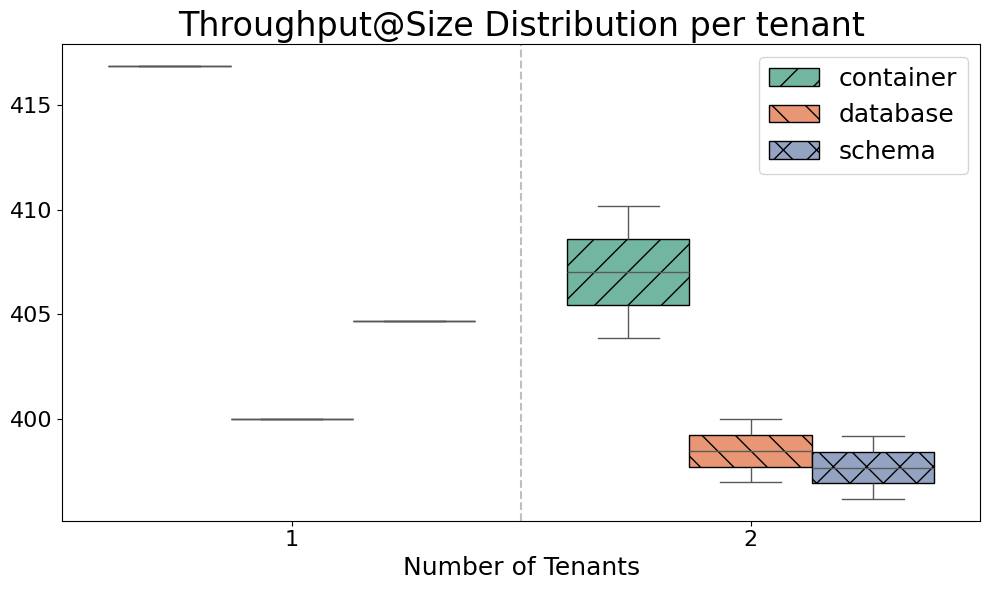

In [9]:
df = df_performance[df_performance['client']==1]
#df = df_performance.copy()
#print(df)
plt.figure(figsize=(10, 6))
# Hatch styles for each type
hatch_map = {
    'container': '/',
    'database': '\\',
    'schema': 'x'
}
hue_order = ['container', 'database', 'schema']

# Plot boxplots grouped by num_tenants and colored by type
ax = sns.boxplot(
    data=df,
    x='num_tenants',
    y='Throughput@Size',
    hue='type',
    palette='Set2'  # consistent colors per type
)

# Add vertical separator lines between groups
# Get the number of unique num_tenants and type
num_groups = df['num_tenants'].nunique()
num_types = df['type'].nunique()

# Extract hue order
hue_order = ax.get_legend_handles_labels()[1]
num_hue = len(hue_order)

# Get hue order from seaborn (types)
_, type_order = ax.get_legend_handles_labels()
num_types = len(type_order)

#print(len(ax.patches))
# Set hatches correctly: patches are grouped by x then by hue
for i, patch in enumerate(ax.patches):
    #print(i)
    type_index = i // (num_groups)
    if type_index >= num_types:
        break
    type_name = type_order[type_index]
    patch.set_hatch(hatch_map.get(type_name, ''))
    #print(hatch_map.get(type_name, ''))
    patch.set_edgecolor('black')
    patch.set_linewidth(1)

# Each num_tenants group has num_types boxes
for i in range(1, num_groups):
    xpos = i - 0.5 #0.5
    ax.axvline(x=xpos, color='gray', linestyle='--', alpha=0.5)


# Update legend with matching hatches
handles, labels = ax.get_legend_handles_labels()
for handle, label in zip(handles, labels):
    hatch = hatch_map.get(label, '')
    handle.set_hatch(hatch)
    handle.set_edgecolor('black')
    handle.set_linewidth(1)

title = "Throughput@Size Distribution per tenant"
plt.title(title, fontsize=24)
plt.xlabel("Number of Tenants")
plt.ylabel("")#"Goodput (requests/second)")
plt.xlabel("Number of Tenants", fontsize=18)
ax.tick_params(axis='both', labelsize=16)
plt.legend(title="Type")
ax.legend(fontsize=18)
plt.tight_layout()
filename = "tpch_" + sanitize_filename(title) + ".png"    
plt.savefig(filename, dpi=300, bbox_inches="tight")
plt.show()

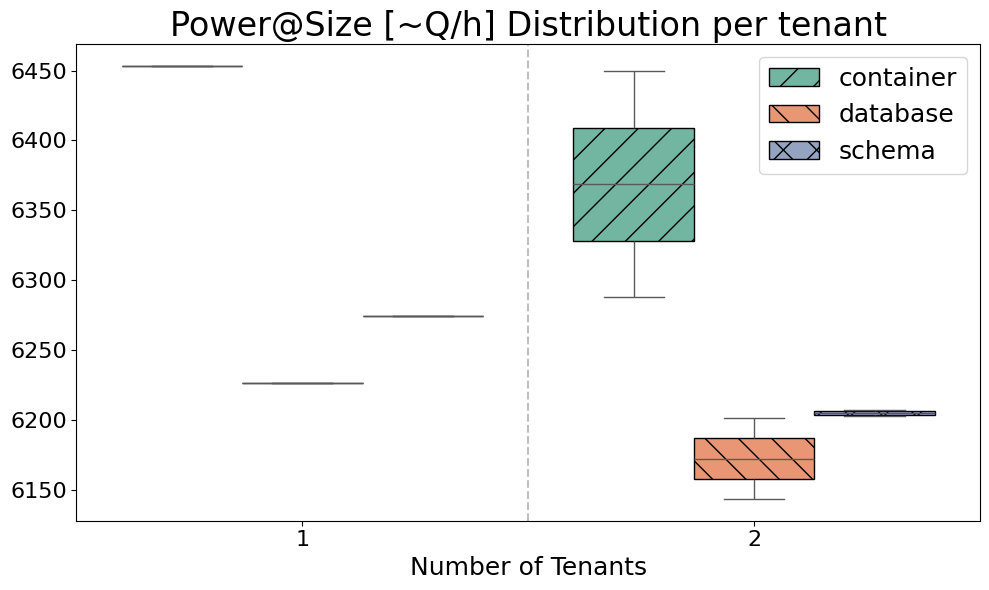

In [10]:
df = df_performance[df_performance['client']==1]
#df = df_performance.copy()
#print(df)
plt.figure(figsize=(10, 6))
# Hatch styles for each type
hatch_map = {
    'container': '/',
    'database': '\\',
    'schema': 'x'
}
hue_order = ['container', 'database', 'schema']

# Plot boxplots grouped by num_tenants and colored by type
ax = sns.boxplot(
    data=df,
    x='num_tenants',
    y='Power@Size [~Q/h]',
    hue='type',
    palette='Set2'  # consistent colors per type
)

# Add vertical separator lines between groups
# Get the number of unique num_tenants and type
num_groups = df['num_tenants'].nunique()
num_types = df['type'].nunique()

# Extract hue order
hue_order = ax.get_legend_handles_labels()[1]
num_hue = len(hue_order)

# Get hue order from seaborn (types)
_, type_order = ax.get_legend_handles_labels()
num_types = len(type_order)

#print(len(ax.patches))
# Set hatches correctly: patches are grouped by x then by hue
for i, patch in enumerate(ax.patches):
    #print(i)
    type_index = i // (num_groups)
    if type_index >= num_types:
        break
    type_name = type_order[type_index]
    patch.set_hatch(hatch_map.get(type_name, ''))
    #print(hatch_map.get(type_name, ''))
    patch.set_edgecolor('black')
    patch.set_linewidth(1)

# Each num_tenants group has num_types boxes
for i in range(1, num_groups):
    xpos = i - 0.5 #0.5
    ax.axvline(x=xpos, color='gray', linestyle='--', alpha=0.5)


# Update legend with matching hatches
handles, labels = ax.get_legend_handles_labels()
for handle, label in zip(handles, labels):
    hatch = hatch_map.get(label, '')
    handle.set_hatch(hatch)
    handle.set_edgecolor('black')
    handle.set_linewidth(1)

title = 'Power@Size [~Q/h] Distribution per tenant'
plt.title(title, fontsize=24)
plt.xlabel("Number of Tenants")
plt.ylabel("")#"Goodput (requests/second)")
plt.xlabel("Number of Tenants", fontsize=18)
ax.tick_params(axis='both', labelsize=16)
plt.legend(title="Type")
ax.legend(fontsize=18)
plt.tight_layout()
filename = "tpch_" + sanitize_filename(title) + ".png"    
plt.savefig(filename, dpi=300, bbox_inches="tight")
plt.show()

In [11]:
df_performance = get_performance_all(codes)
df_performance

,client,Throughput@Size,type,num_tenants
0,1,814.03,container,2
1,2,820.09,container,2
0,1,796.99,database,2
1,2,802.03,database,2
0,1,795.39,schema,2
1,2,795.78,schema,2
0,1,416.84,container,1
1,2,412.29,container,1
0,1,400.00,database,1
1,2,402.64,database,1


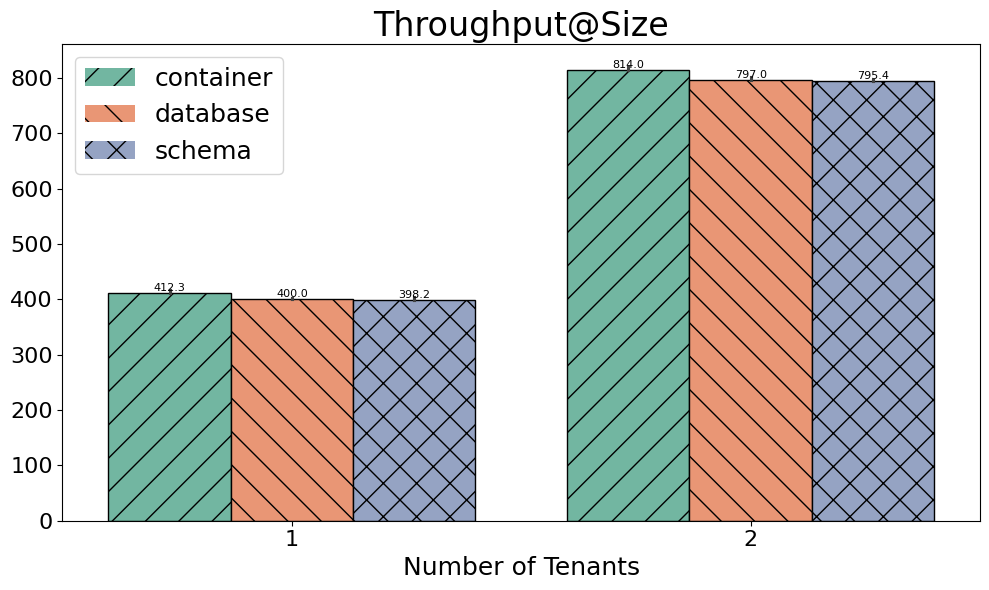

In [12]:
plot_bars(df_performance, y='Throughput@Size', title='Throughput@Size', estimator='min')

In [13]:
df_performance = get_loading_time_max_all(codes)
df_performance

,time_load,time_ingest,time_check,pods,tenant,client,datadisk,type,num_tenants
PostgreSQL-BHT-1-0-1-1,2436.0,875.0,1558.0,1,0,1,27211,container,2
PostgreSQL-BHT-1-0-2-1,2436.0,875.0,1558.0,1,0,2,27211,container,2
PostgreSQL-BHT-1-1-1-1,2419.0,871.0,1544.0,1,1,1,27211,container,2
PostgreSQL-BHT-1-1-2-1,2419.0,871.0,1544.0,1,1,2,27211,container,2
PostgreSQL-BHT-2-1-1,3616.0,1206.0,2172.0,2,,1,54413,database,2
PostgreSQL-BHT-2-1-2,3616.0,1206.0,2172.0,2,,1,54413,database,2
PostgreSQL-BHT-2-2-1,3616.0,1206.0,2172.0,2,,2,54413,database,2
PostgreSQL-BHT-2-2-2,3616.0,1206.0,2172.0,2,,2,54413,database,2
PostgreSQL-BHT-2-1-1,3103.0,1194.0,1905.0,2,,1,54383,schema,2
PostgreSQL-BHT-2-1-2,3103.0,1194.0,1905.0,2,,1,54383,schema,2


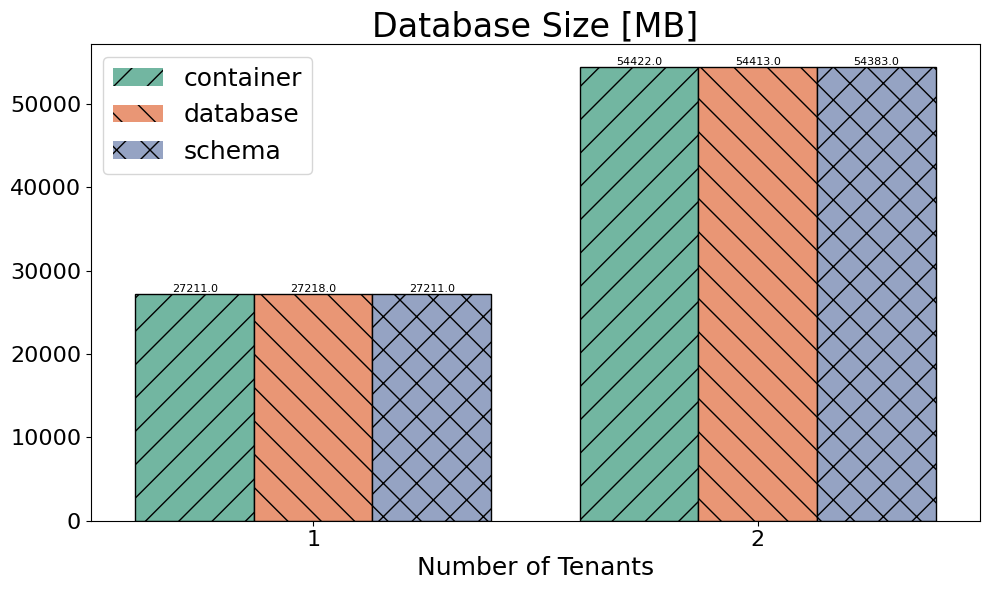

In [14]:
df_performance_first = df_performance[df_performance['client'] == '1']
# Divide datadisk by the count of rows with the same type and num_tenants
df = df_performance_first.copy()
# Create a mask for rows where type is not "container"
mask = df['type'] != 'container'

# Only apply the group count to the relevant rows
group_counts = df[mask].groupby(['type', 'num_tenants'])['datadisk'].transform('count')

# Initialize the column with NaN (or 0, if preferred)
df['datadisk_normalized'] = df['datadisk']

# Apply the normalized value only where the mask is True
df.loc[mask, 'datadisk_normalized'] = df.loc[mask, 'datadisk'] / group_counts

plot_bars(df, y='datadisk_normalized', title='Database Size [MB]', estimator='sum')

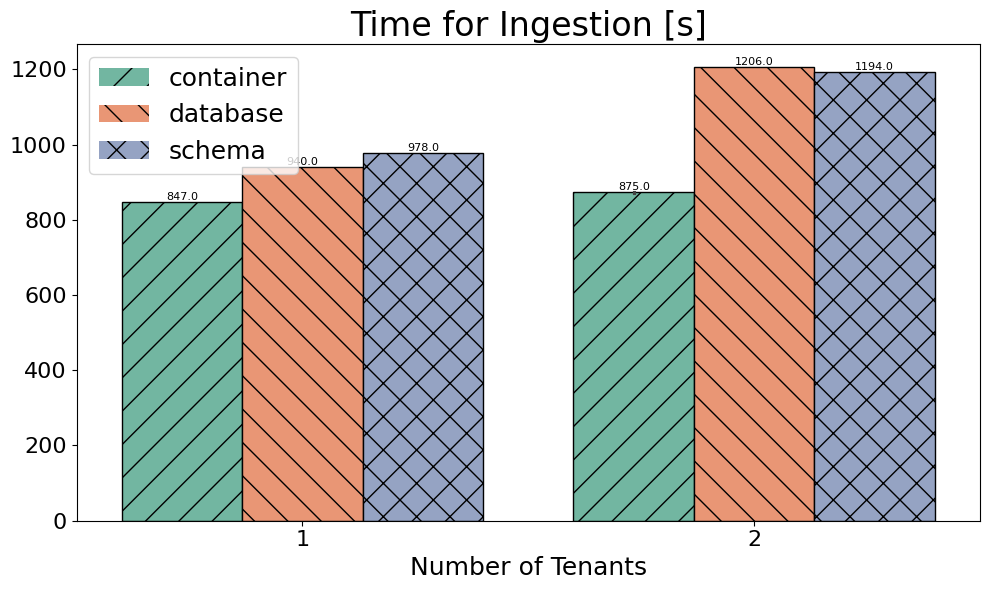

In [15]:
plot_bars(df_performance, y='time_ingest', title='Time for Ingestion [s]', estimator='max')

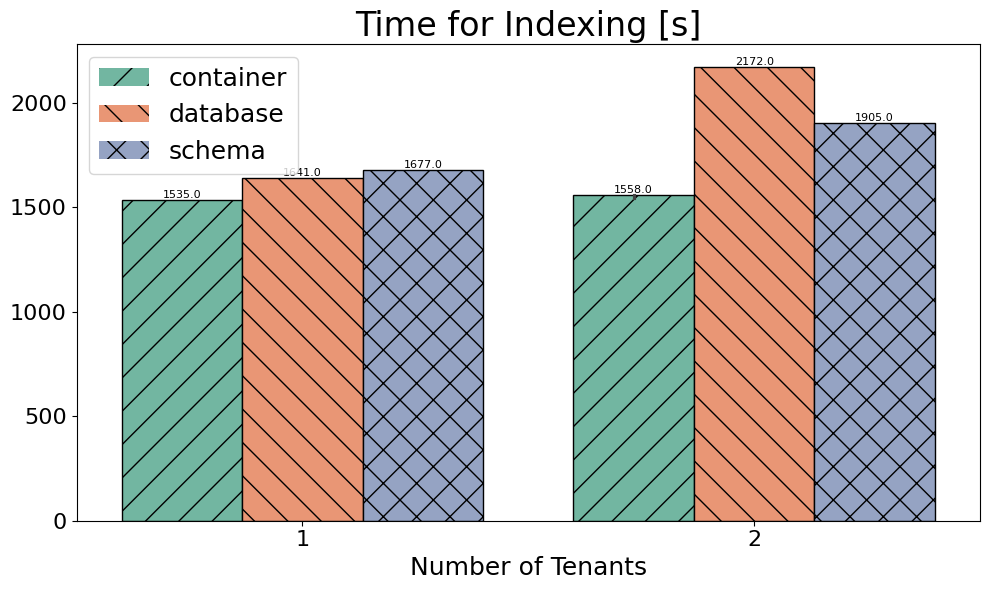

In [16]:
plot_bars(df_performance, y='time_check', title='Time for Indexing [s]', estimator='max')

In [18]:
df_performance = get_monitoring_stream_all(codes)
df_performance = df_performance[df_performance['client'] == '1']
df_performance

,client,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU,type,num_tenants
0,1,21122.16,102.01,133.83,15.92,container,2
0,1,21627.18,73.43,104.86,14.84,database,2
0,1,21782.59,58.97,90.77,14.08,schema,2
0,1,10249.41,57.44,73.35,7.95,container,1
0,1,10597.67,57.45,73.36,7.98,database,1
0,1,10827.06,57.44,73.35,7.98,schema,1


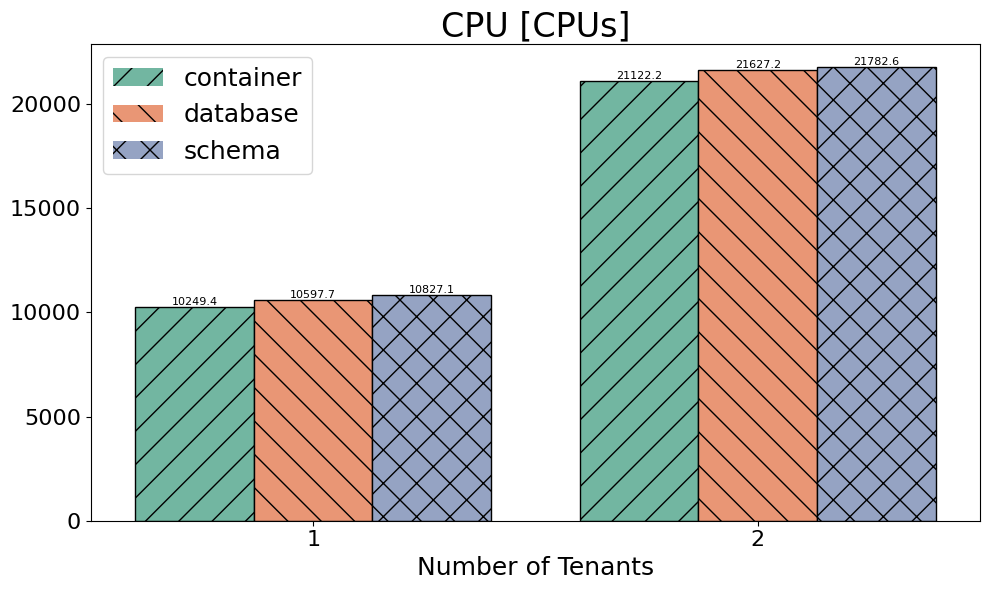

In [19]:
plot_bars(df_performance, y='CPU [CPUs]', title='CPU [CPUs]', estimator='max')

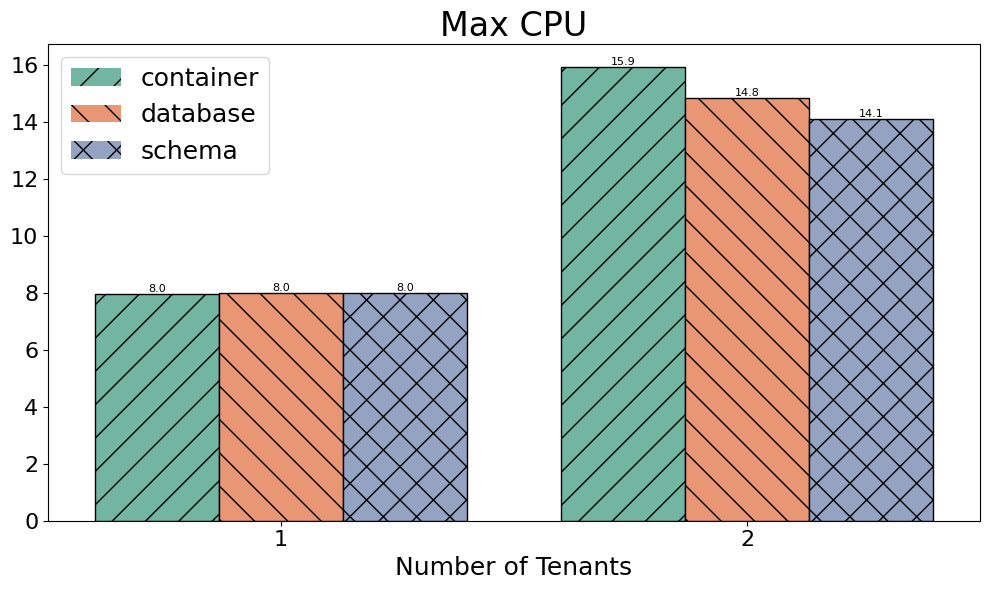

In [20]:
plot_bars(df_performance, y='Max CPU', title='Max CPU', estimator='sum')

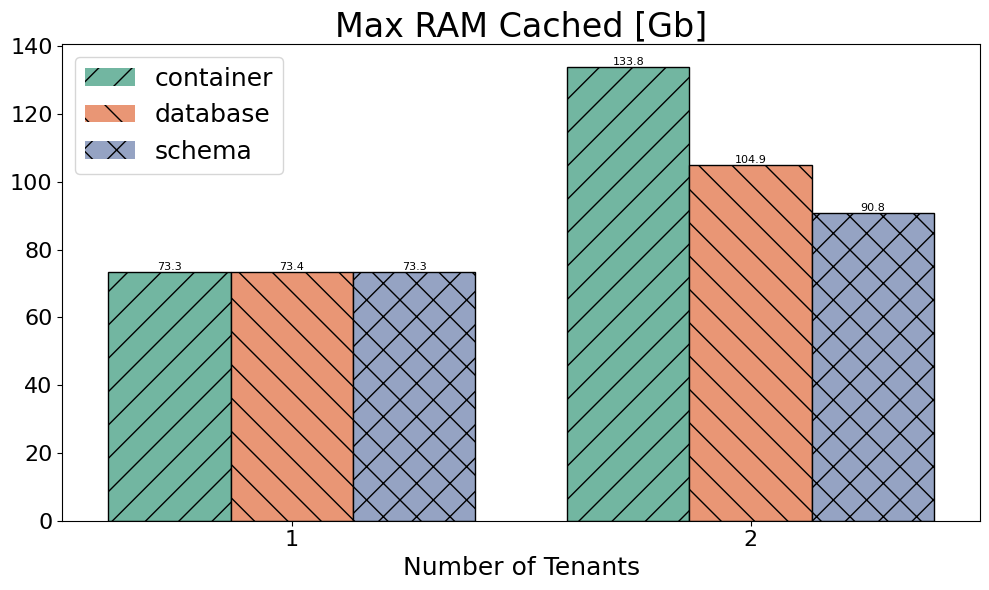

In [21]:
plot_bars(df_performance, y='Max RAM Cached [Gb]', title='Max RAM Cached [Gb]', estimator='sum')

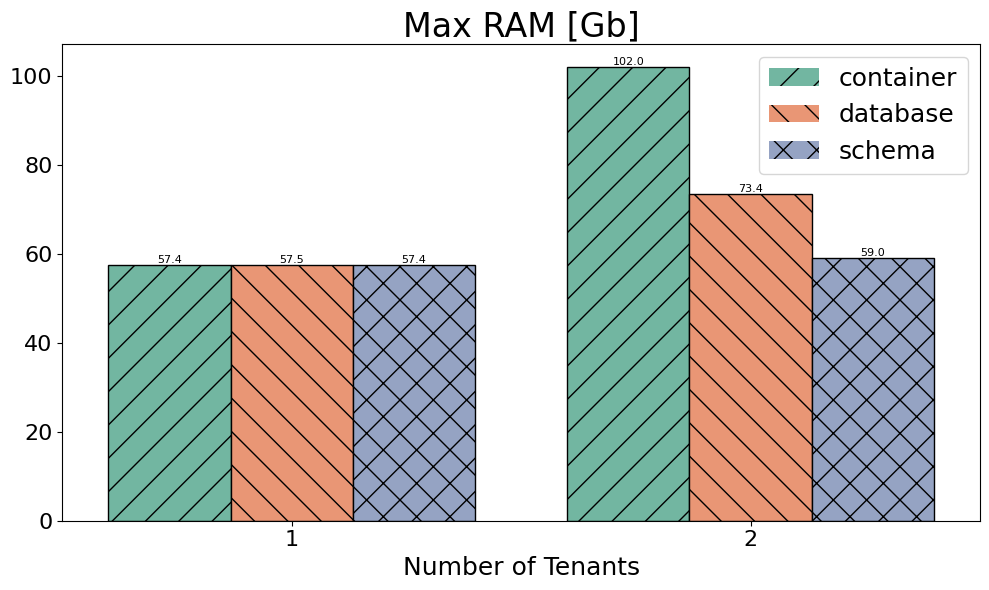

In [22]:
plot_bars(df_performance, y='Max RAM [Gb]', title='Max RAM [Gb]', estimator='sum')

# Single Experiment

In [ ]:
code = '1750741356'
evaluation = evaluators.benchbase(code=code, path=path)
workload = get_workload(code)

In [ ]:
df=get_performance_single(evaluation)
df['type']=workload['tenant_per']
df['num_tenants']=workload['num_tenants']
df.T

In [ ]:
get_loading_time_max(evaluation)

In [ ]:
get_monitoring_stream_single(evaluation).sort_values('client')

In [ ]:
get_monitoring_stream(evaluation)

In [ ]:
code=codes[9]
evaluate = inspector.inspector(path)
evaluate.load_experiment(code=code, silent=True)
query_properties = evaluate.get_experiment_query_properties()
query_properties

In [ ]:
print("\n### Power@Size ((3600*SF)/(geo times))")
df = evaluate.get_aggregated_experiment_statistics(type='timer', name='execution', query_aggregate='Median', total_aggregate='Geo')
df = (df/1000.0).sort_index().astype('float')
df['Power@Size [~Q/h]'] = float(parameter.defaultParameters['SF'])*3600./df
#df.columns = ['Power@Size [~Q/h]']
df_power = df.copy()
print(df.round(2))
print(parameter.defaultParameters['SF'])

In [ ]:
print("\n### Geometric Mean of Medians of Timer Run [s]")
df = evaluate.get_aggregated_experiment_statistics(type='timer', name='run', query_aggregate='Median', total_aggregate='Geo')
df = (df/1000.0).sort_index()
df.columns = ['Geo Times [s]']
df_geo_mean_runtime = df.copy()
print(df.round(2))


In [ ]:
df = pd.concat([df_power, df_geo_mean_runtime], axis=1)
df

In [ ]:
#df_time = df.copy()
df_merged_time = pd.DataFrame()
for connection_nr, connection in evaluate.benchmarks.dbms.items():
    df_time = pd.DataFrame()
    c = connection.connectiondata
    connection_name = c['name']
    orig_name = c['orig_name']
    #print(orig_name)
    eva = evaluate.get_experiment_connection_properties(c['name'])
    df_time.index = [connection_name]
    #df_time['SF'] = int(SF)
    #print(c)
    #print(connection.name)
    #print(connection.connection)
    df_time['orig_name'] = orig_name
    df_time['SF'] = float(c['parameter']['connection_parameter']['loading_parameters']['SF'])
    df_time['pods'] = int(c['parameter']['connection_parameter']['loading_parameters']['PODS_PARALLEL'])
    #df_time['threads'] = int(c['parameter']['connection_parameter']['loading_parameters']['MYSQL_LOADING_THREADS'])
    df_time['num_experiment'] = int(c['parameter']['numExperiment'])
    df_time['num_client'] = int(c['parameter']['client'])
    df_time['benchmark_start'] = eva['times']['total'][c['name']]['time_start']
    df_time['benchmark_end'] = eva['times']['total'][c['name']]['time_end']
    df_time['benchmark_total_time'] = df_time['benchmark_end'] - df_time['benchmark_start']
    #print(df_time)
    df_merged_time = pd.concat([df_merged_time, df_time])

df_merged_time#.sort_values('orig_name')

In [ ]:
df = pd.concat([df, df_merged_time], axis=1)
df = df.sort_values('orig_name')
df

In [ ]:
df['Power@Size [~Q/h]'] = df['SF']*3600./df['total_timer_execution']
df

In [ ]:
def map_index_to_queryname(numQuery):
    if numQuery[1:] in query_properties and 'config' in query_properties[numQuery[1:]] and 'title' in query_properties[numQuery[1:]]['config']:
        return query_properties[numQuery[1:]]['config']['title']
    else:
        return numQuery

def get_benchmark_df():
    code=codes[9]
    evaluate = inspector.inspector(path)
    evaluate.load_experiment(code=code, silent=True)
    query_properties = evaluate.get_experiment_query_properties()
    #print(query_properties)
    print(evaluate.e)#['connectionmanagement']['numRun'])
    num_of_queries = 0
    df = evaluate.get_aggregated_query_statistics(type='latency', name='execution', query_aggregate='Mean')
    if not df is None:
        df = df.sort_index().T.round(2)
        df.index = df.index.map(map_index_to_queryname)
        #print(df)
        num_of_queries = len(df.index)
    #print("\n### Power@Size ((3600*SF)/(geo times))")
    df = evaluate.get_aggregated_experiment_statistics(type='timer', name='execution', query_aggregate='Median', total_aggregate='Geo')
    df = (df/1000.0).sort_index().astype('float')
    df['Power@Size [~Q/h]'] = float(parameter.defaultParameters['SF'])*3600./df
    #df.columns = ['Power@Size [~Q/h]']
    df_power = df.copy()
    #print(df.round(2))
    #print(parameter.defaultParameters['SF'])
    #print("\n### Geometric Mean of Medians of Timer Run [s]")
    df = evaluate.get_aggregated_experiment_statistics(type='timer', name='run', query_aggregate='Median', total_aggregate='Geo')
    df = (df/1000.0).sort_index()
    df.columns = ['Geo Times [s]']
    df_geo_mean_runtime = df.copy()
    #print(df.round(2))
    df = pd.concat([df_power, df_geo_mean_runtime], axis=1)
    #df_time = df.copy()
    df_merged_time = pd.DataFrame()
    for connection_nr, connection in evaluate.benchmarks.dbms.items():
        df_time = pd.DataFrame()
        c = connection.connectiondata
        connection_name = c['name']
        orig_name = c['orig_name']
        eva = evaluate.get_experiment_connection_properties(c['name'])
        df_time.index = [connection_name]
        #df_time['SF'] = int(SF)
        #print(c)
        #print(connection.name)
        #print(connection.connection)
        df_time['orig_name'] = orig_name
        df_time['SF'] = float(c['parameter']['connection_parameter']['loading_parameters']['SF'])
        df_time['pods'] = int(c['parameter']['connection_parameter']['loading_parameters']['PODS_PARALLEL'])
        #df_time['threads'] = int(c['parameter']['connection_parameter']['loading_parameters']['MYSQL_LOADING_THREADS'])
        df_time['num_experiment'] = int(c['parameter']['numExperiment'])
        df_time['num_client'] = int(c['parameter']['client'])
        df_time['benchmark_start'] = eva['times']['total'][c['name']]['time_start']
        df_time['benchmark_end'] = eva['times']['total'][c['name']]['time_end']
        df_merged_time = pd.concat([df_merged_time, df_time])
    df_time = df_merged_time.sort_index()
    benchmark_start = df_time.groupby(['orig_name', 'SF', 'num_experiment', 'num_client']).min('benchmark_start')
    benchmark_end = df_time.groupby(['orig_name', 'SF', 'num_experiment', 'num_client']).max('benchmark_end')
    df_benchmark = pd.DataFrame(benchmark_end['benchmark_end'] - benchmark_start['benchmark_start'])
    df_benchmark.columns = ['time [s]']
    benchmark_count = df_time.groupby(['orig_name', 'SF', 'num_experiment', 'num_client']).count()
    df_benchmark['count'] = benchmark_count['benchmark_end']
    df_benchmark['SF2'] = df_benchmark.index.map(lambda x: x[1])
    df_benchmark['Throughput@Size'] = (num_of_queries*3600.*df_benchmark['count']/df_benchmark['time [s]']*df_benchmark['SF2']).round(2)
    #df_benchmark['Throughput@Size [~GB/h]'] = (22*3600.*df_benchmark['count']/df_benchmark['time [s]']*df_benchmark['SF']).round(2)
    index_names = list(df_benchmark.index.names)
    #print(index_names)
    index_names[0] = "DBMS"
    df_benchmark.rename_axis(index_names, inplace=True)
    df_benchmark = df_benchmark.reset_index(level=['SF', 'num_experiment', 'num_client'])
    #print(df_benchmark)
    #return df_benchmark
    df.index = df.index.map(lambda x: str(x)[:-2])
    df = pd.concat([df, df_benchmark], axis=1)
    df.drop('SF2', axis=1, inplace=True)
    df.rename(columns={'num_experiment': 'experiment_run'}, inplace=True)
    df.rename(columns={'num_client': 'client'}, inplace=True)
    #df = df.sort_values('orig_name')
    df['Power@Size [~Q/h]'] = df['SF']*3600./df['total_timer_execution']
    return df

In [ ]:
get_benchmark_df()

# Efficiency

In [31]:
df_performance_monitoring = get_monitoring_stream_all(codes)
df_performance_monitoring["client"] = df_performance_monitoring["client"].astype(int)
#df_performance_monitoring = df_performance_monitoring[df_performance_monitoring['client'] == '1']
df_performance_monitoring

,client,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU,type,num_tenants
0,1,21122.16,102.01,133.83,15.92,container,2
1,2,20536.07,116.66,148.48,15.94,container,2
0,1,21627.18,73.43,104.86,14.84,database,2
1,2,21213.02,73.99,105.29,15.30,database,2
0,1,21782.59,58.97,90.77,14.08,schema,2
1,2,21532.46,73.67,105.46,14.96,schema,2
0,1,10249.41,57.44,73.35,7.95,container,1
1,2,10563.69,58.33,74.24,7.96,container,1
0,1,10597.67,57.45,73.36,7.98,database,1
1,2,10686.47,58.34,74.26,7.96,database,1


In [32]:
df_performance = get_performance_all(codes)
df_performance["client"] = df_performance["client"].astype(int)
#df_performance = df_performance[df_performance['client'] == '2']
df_performance

,client,Throughput@Size,type,num_tenants
0,1,814.03,container,2
1,2,820.09,container,2
0,1,796.99,database,2
1,2,802.03,database,2
0,1,795.39,schema,2
1,2,795.78,schema,2
0,1,416.84,container,1
1,2,412.29,container,1
0,1,400.00,database,1
1,2,402.64,database,1


In [33]:
merged_df = pd.merge(df_performance, df_performance_monitoring, on=['type', 'num_tenants', 'client'], how='inner')
merged_df

,client,Throughput@Size,type,num_tenants,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU
0,1,814.03,container,2,21122.16,102.01,133.83,15.92
1,2,820.09,container,2,20536.07,116.66,148.48,15.94
2,1,796.99,database,2,21627.18,73.43,104.86,14.84
3,2,802.03,database,2,21213.02,73.99,105.29,15.30
4,1,795.39,schema,2,21782.59,58.97,90.77,14.08
5,2,795.78,schema,2,21532.46,73.67,105.46,14.96
6,1,416.84,container,1,10249.41,57.44,73.35,7.95
7,2,412.29,container,1,10563.69,58.33,74.24,7.96
8,1,400.00,database,1,10597.67,57.45,73.36,7.98
9,2,402.64,database,1,10686.47,58.34,74.26,7.96


In [39]:
merged_df['CPUs/Throughput'] = merged_df['CPU [CPUs]'] / merged_df['Throughput@Size'] / 3600. * 1000.

merged_df

,client,Throughput@Size,type,num_tenants,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU,CPUs/Throughput
0,1,814.03,container,2,21122.16,102.01,133.83,15.92,7.207679
1,2,820.09,container,2,20536.07,116.66,148.48,15.94,6.955900
2,1,796.99,database,2,21627.18,73.43,104.86,14.84,7.537798
3,2,802.03,database,2,21213.02,73.99,105.29,15.30,7.346989
4,1,795.39,schema,2,21782.59,58.97,90.77,14.08,7.607236
5,2,795.78,schema,2,21532.46,73.67,105.46,14.96,7.516197
6,1,416.84,container,1,10249.41,57.44,73.35,7.95,6.830099
7,2,412.29,container,1,10563.69,58.33,74.24,7.96,7.117219
8,1,400.00,database,1,10597.67,57.45,73.36,7.98,7.359493
9,2,402.64,database,1,10686.47,58.34,74.26,7.96,7.372501


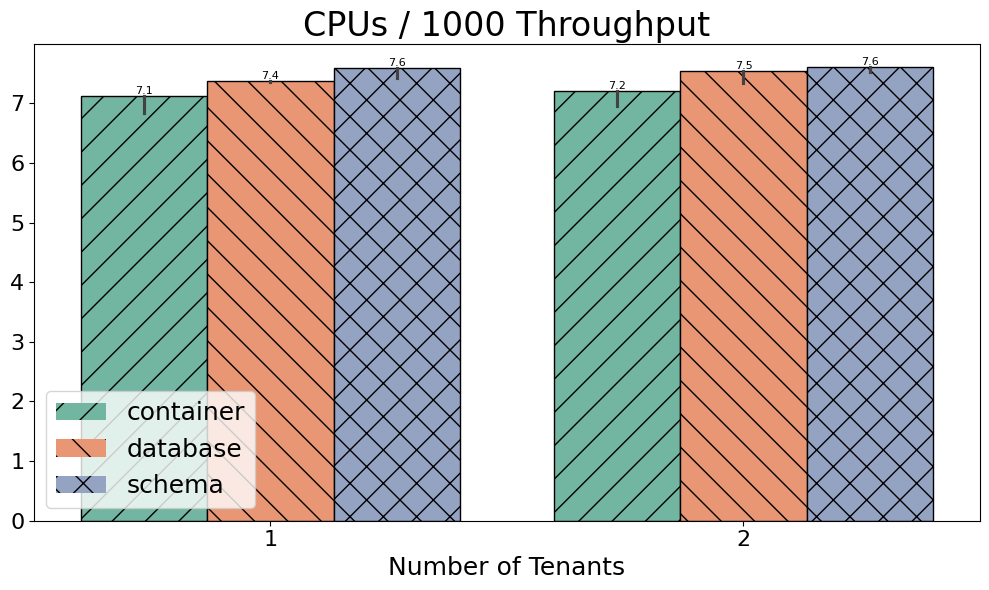

In [40]:
plot_bars(merged_df, y='CPUs/Throughput', title='CPUs / 1000 Throughput', estimator='max')

In [43]:
merged_df['RAM/Throughput'] = merged_df['Max RAM [Gb]'] / merged_df['Throughput@Size'] * 1000.

merged_df

,client,Throughput@Size,type,num_tenants,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU,CPUs/Throughput,RAM/Throughput
0,1,814.03,container,2,21122.16,102.01,133.83,15.92,7.207679,125.314792
1,2,820.09,container,2,20536.07,116.66,148.48,15.94,6.955900,142.252680
2,1,796.99,database,2,21627.18,73.43,104.86,14.84,7.537798,92.134155
3,2,802.03,database,2,21213.02,73.99,105.29,15.30,7.346989,92.253407
4,1,795.39,schema,2,21782.59,58.97,90.77,14.08,7.607236,74.139730
5,2,795.78,schema,2,21532.46,73.67,105.46,14.96,7.516197,92.575838
6,1,416.84,container,1,10249.41,57.44,73.35,7.95,6.830099,137.798676
7,2,412.29,container,1,10563.69,58.33,74.24,7.96,7.117219,141.478086
8,1,400.00,database,1,10597.67,57.45,73.36,7.98,7.359493,143.625000
9,2,402.64,database,1,10686.47,58.34,74.26,7.96,7.372501,144.893702


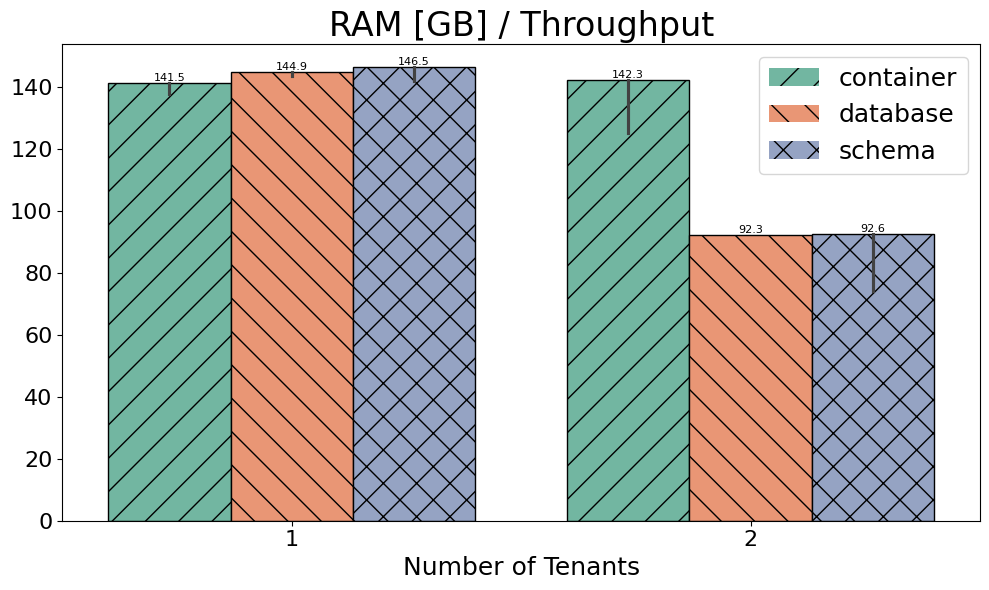

In [45]:
plot_bars(merged_df, y='RAM/Throughput', title='RAM [GB] / Throughput', estimator='max')

In [49]:
client = 1

df_performance_monitoring = get_monitoring_stream_all(codes)
df_performance_monitoring["client"] = df_performance_monitoring["client"].astype(int)
df_performance_monitoring = df_performance_monitoring[df_performance_monitoring['client'] == client]
df_performance = get_performance_all(codes)
df_performance["client"] = df_performance["client"].astype(int)
df_performance = df_performance[df_performance['client'] == client]
merged_df = pd.merge(df_performance, df_performance_monitoring, on=['type', 'num_tenants', 'client'], how='inner')
merged_df['RAM/Throughput'] = merged_df['Max RAM [Gb]'] / merged_df['Throughput@Size'] * 1000.
merged_df['CPUs/Throughput'] = merged_df['CPU [CPUs]'] / merged_df['Throughput@Size'] / 3600. * 1000.

merged_df

,client,Throughput@Size,type,num_tenants,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU,RAM/Throughput,CPUs/Throughput
0,1,814.03,container,2,21122.16,102.01,133.83,15.92,125.314792,7.207679
1,1,796.99,database,2,21627.18,73.43,104.86,14.84,92.134155,7.537798
2,1,795.39,schema,2,21782.59,58.97,90.77,14.08,74.139730,7.607236
3,1,416.84,container,1,10249.41,57.44,73.35,7.95,137.798676,6.830099
4,1,400.00,database,1,10597.67,57.45,73.36,7.98,143.625000,7.359493
5,1,404.70,schema,1,10827.06,57.44,73.35,7.98,141.932296,7.431472


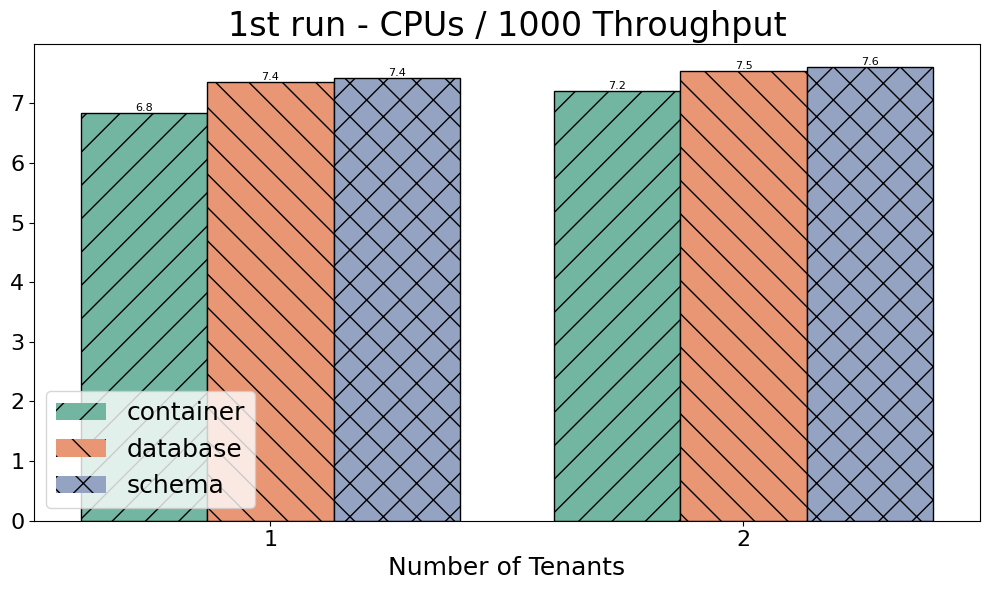

In [52]:
plot_bars(merged_df, y='CPUs/Throughput', title='1st run - CPUs / 1000 Throughput', estimator='max')

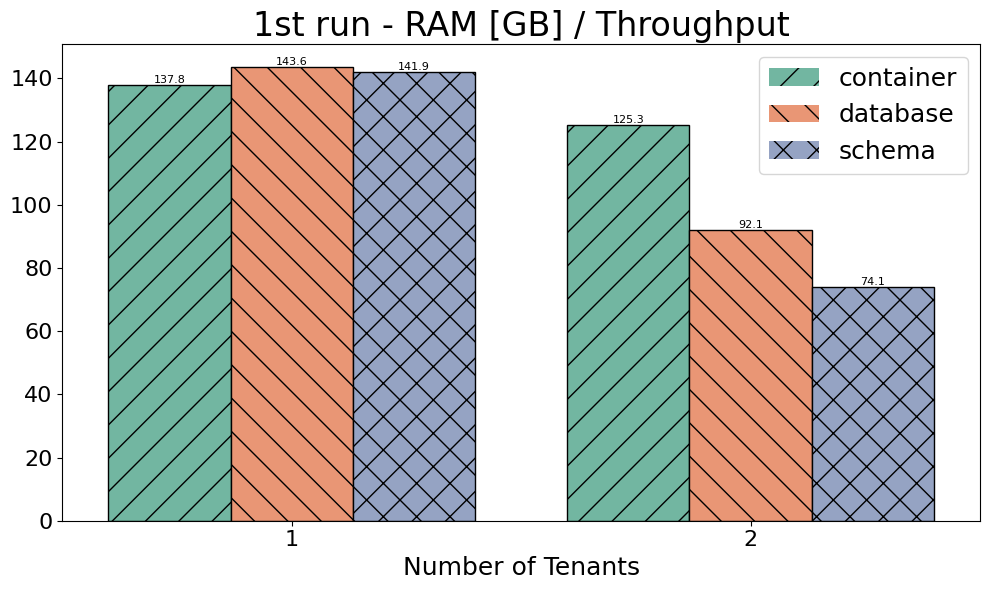

In [53]:
plot_bars(merged_df, y='RAM/Throughput', title='1st run - RAM [GB] / Throughput', estimator='max')

In [54]:
client = 2

df_performance_monitoring = get_monitoring_stream_all(codes)
df_performance_monitoring["client"] = df_performance_monitoring["client"].astype(int)
df_performance_monitoring = df_performance_monitoring[df_performance_monitoring['client'] == client]
df_performance = get_performance_all(codes)
df_performance["client"] = df_performance["client"].astype(int)
df_performance = df_performance[df_performance['client'] == client]
merged_df = pd.merge(df_performance, df_performance_monitoring, on=['type', 'num_tenants', 'client'], how='inner')
merged_df['RAM/Throughput'] = merged_df['Max RAM [Gb]'] / merged_df['Throughput@Size'] * 1000.
merged_df['CPUs/Throughput'] = merged_df['CPU [CPUs]'] / merged_df['Throughput@Size'] / 3600. * 1000.

merged_df

,client,Throughput@Size,type,num_tenants,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU,RAM/Throughput,CPUs/Throughput
0,2,820.09,container,2,20536.07,116.66,148.48,15.94,142.252680,6.955900
1,2,802.03,database,2,21213.02,73.99,105.29,15.30,92.253407,7.346989
2,2,795.78,schema,2,21532.46,73.67,105.46,14.96,92.575838,7.516197
3,2,412.29,container,1,10563.69,58.33,74.24,7.96,141.478086,7.117219
4,2,402.64,database,1,10686.47,58.34,74.26,7.96,144.893702,7.372501
5,2,398.19,schema,1,10890.06,58.33,74.24,7.95,146.487858,7.596918


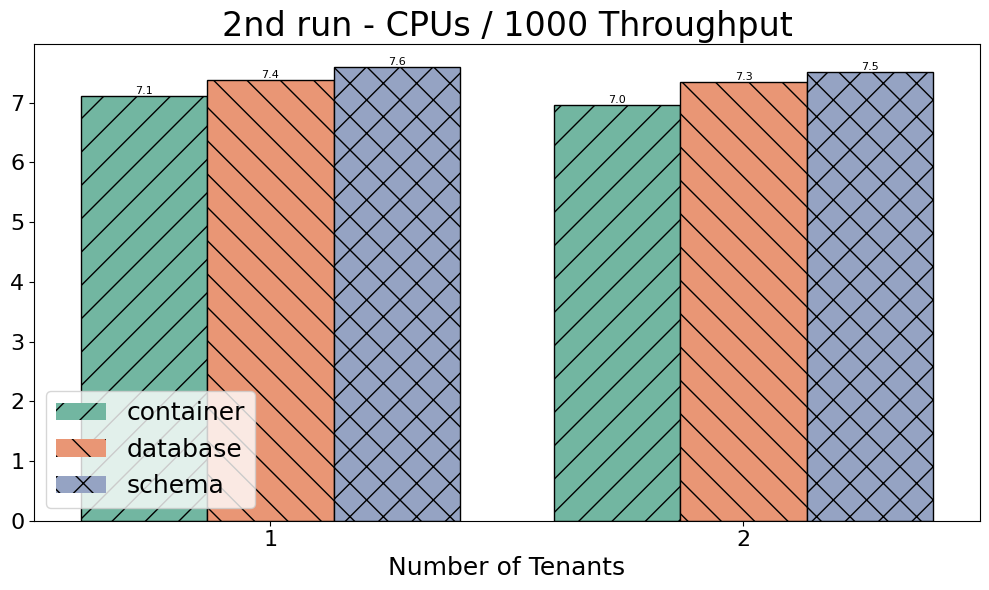

In [55]:
plot_bars(merged_df, y='CPUs/Throughput', title='2nd run - CPUs / 1000 Throughput', estimator='max')

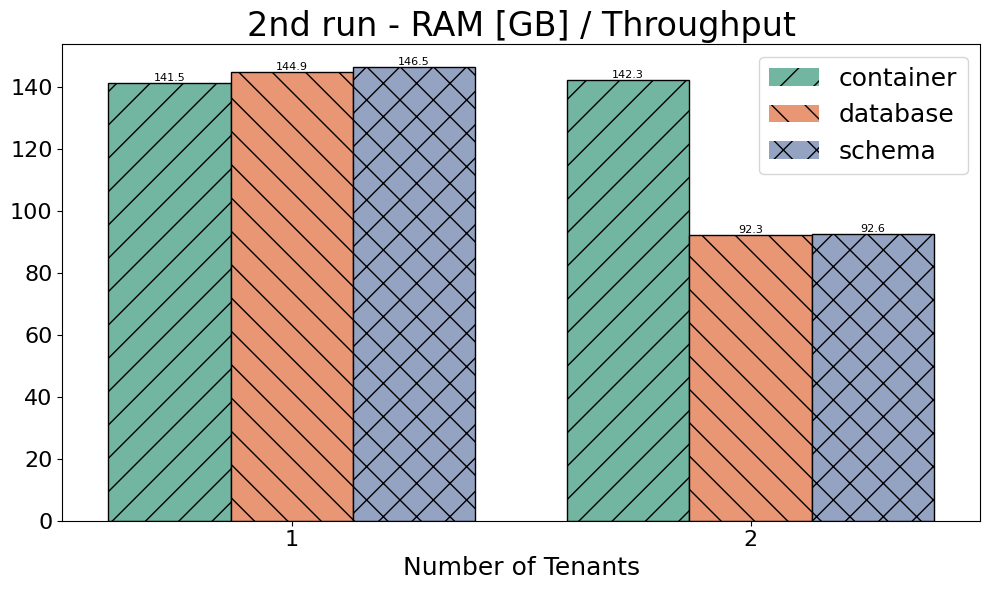

In [56]:
plot_bars(merged_df, y='RAM/Throughput', title='2nd run - RAM [GB] / Throughput', estimator='max')